Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 24000 files belonging to 50 classes.
Using 19200 files for training.
Found 24000 files belonging to 50 classes.
Using 4800 files for validation.
Classes: 50


/tmp/ipython-input-3711385349.py:72: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 176s 403ms/step - accuracy: 0.0555 - loss: 3.8840 - val_accuracy: 0.3565 - val_loss: 3.0886
Epoch 2/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3132 - loss: 2.9720 - val_accuracy: 0.5775 - val_loss: 2.4408
Epoch 3/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5119 - loss: 2.3604 - val_accuracy: 0.6771 - val_loss: 1.9972
Epoch 4/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6178 - loss: 1.9539 - val_accuracy: 0.7267 - val_loss: 1.6882
Epoch 5/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6798 - loss: 1.6552 - val_accuracy: 0.7604 - val_loss: 1.4625
Epoch 6/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7247 - loss: 1.4460 - val_accuracy: 0.7854 - val_loss: 1.2917
Epoch 7/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7534 - loss: 1.2850 - val_accuracy: 0.8017 - val_loss: 1.1580
Epoch 8/18
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7789 - loss: 1.1576 

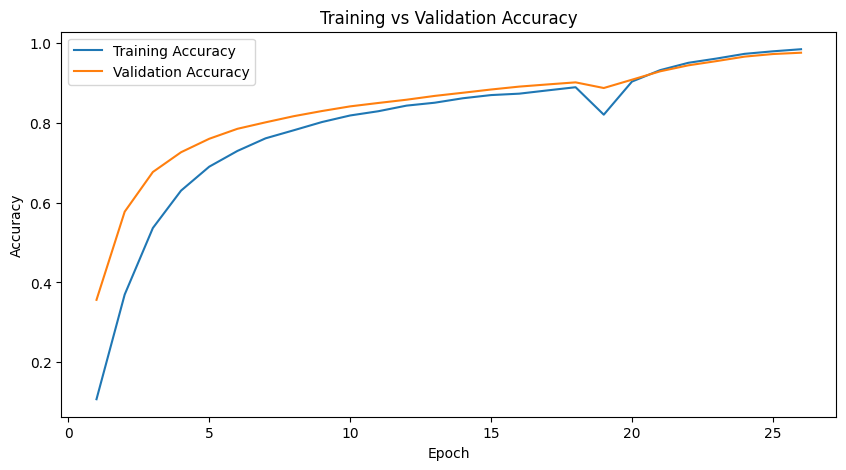

Saved accuracy chart: /content/drive/MyDrive/Birds_Dataset3_model/training_validation_accuracy.png


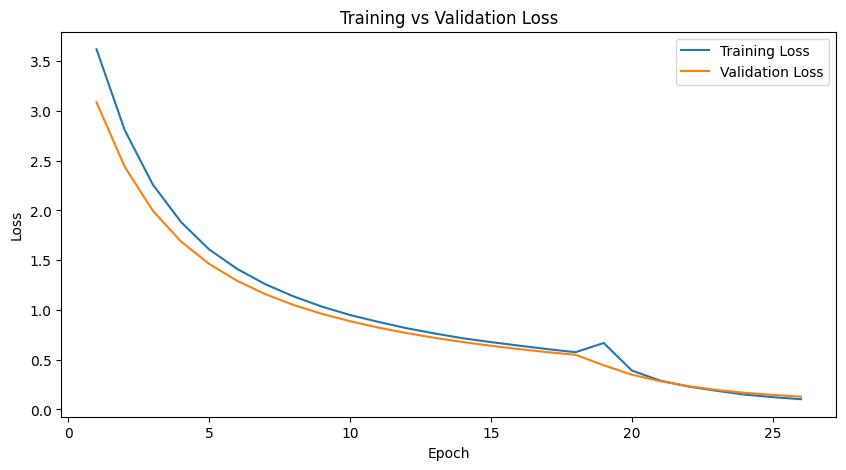

Saved loss chart: /content/drive/MyDrive/Birds_Dataset3_model/training_validation_loss.png
Saved artifact at '/content/drive/MyDrive/Birds_Dataset3_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 50), dtype=tf.float32, name=None)
Captures:
  134973978813136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970945109456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970945108880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970945109840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970945109648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970892977168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970892978896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970892979088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134970892977936: TensorSpec(sha

In [ ]:
# -*- coding: utf-8 -*-
import os
import time
import csv
from datetime import timedelta

import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# ---------------- CONFIG ----------------
DATA_DIR = "/content/drive/MyDrive/Birds_Dataset3"
EXPORT_DIR = "/content/drive/MyDrive/Birds_Dataset3_model"
CSV_OUTPUT = f"{EXPORT_DIR}/class_names.csv"

IMG_SIZE = 300
BATCH_SIZE = 78 #64
AUTOTUNE = tf.data.AUTOTUNE

INITIAL_EPOCHS = 18 #10
FINE_TUNE_EPOCHS = 8 #5
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

os.makedirs(EXPORT_DIR, exist_ok=True)

# ---------------- LOAD DATA ----------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", num_classes)

# ---------------- PREPROCESS / AUGMENTATION ----------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def prep(ds, aug=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    if aug:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)

train_ds = prep(train_ds.shuffle(1000), aug=True)
val_ds = prep(val_ds, aug=False)

# ---------------- BUILD MODEL ----------------
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# ---------------- TRAIN (TIMED) ----------------
total_start = time.perf_counter()

stage1_start = time.perf_counter()
history1 = model.fit(train_ds, epochs=INITIAL_EPOCHS, validation_data=val_ds)
stage1_end = time.perf_counter()

# ---------------- FINE TUNE ----------------
base.trainable = True
fine_tune_at = len(base.layers) - 30
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

stage2_start = time.perf_counter()
history2 = model.fit(
    train_ds,
    initial_epoch=INITIAL_EPOCHS,
    epochs=TOTAL_EPOCHS,
    validation_data=val_ds
)
stage2_end = time.perf_counter()

total_end = time.perf_counter()

stage1_s = stage1_end - stage1_start
stage2_s = stage2_end - stage2_start
total_s = total_end - total_start

print("Training time (stage 1):", str(timedelta(seconds=int(stage1_s))), f"({stage1_s:.1f} s)")
print("Training time (stage 2):", str(timedelta(seconds=int(stage2_s))), f"({stage2_s:.1f} s)")
print("Training time (total):  ", str(timedelta(seconds=int(total_s))), f"({total_s:.1f} s)")

# ---------------- PLOT TRAINING CURVES ----------------
acc = history1.history.get("accuracy", []) + history2.history.get("accuracy", [])
val_acc = history1.history.get("val_accuracy", []) + history2.history.get("val_accuracy", [])
loss = history1.history.get("loss", []) + history2.history.get("loss", [])
val_loss = history1.history.get("val_loss", []) + history2.history.get("val_loss", [])

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
acc_chart_path = f"{EXPORT_DIR}/training_validation_accuracy.png"
plt.savefig(acc_chart_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved accuracy chart:", acc_chart_path)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
loss_chart_path = f"{EXPORT_DIR}/training_validation_loss.png"
plt.savefig(loss_chart_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved loss chart:", loss_chart_path)

# ---------------- EXPORT KERAS MODEL ----------------
model.export(EXPORT_DIR)
print("SavedModel exported to:", EXPORT_DIR)

# ---------------- EXPORT FLOAT TFLITE (BEST QUALITY) ----------------
converter = tf.lite.TFLiteConverter.from_saved_model(EXPORT_DIR)
tflite_float = converter.convert()

float_path = f"{EXPORT_DIR}/bird_classifier_float.tflite"
with open(float_path, "wb") as f:
    f.write(tflite_float)
print("Saved FLOAT TFLite:", float_path)

# ---------------- INT8 QUANTIZATION WITH REPRESENTATIVE DATA ----------------
def rep_data_gen():
    for images, _ in train_ds.take(100):
        yield [images]

converter = tf.lite.TFLiteConverter.from_saved_model(EXPORT_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()

int8_path = f"{EXPORT_DIR}/bird_classifier_int8.tflite"
with open(int8_path, "wb") as f:
    f.write(tflite_int8)
print("Saved INT8 TFLite:", int8_path)

# ---------------- SAVE CLASS NAMES ----------------
with open(CSV_OUTPUT, "w", newline="") as f:
    writer = csv.writer(f)
    for name in class_names:
        writer.writerow([name])
print("Saved classes:", CSV_OUTPUT)
